In [0]:
import pandas as pd
import numpy as np
import os
import datetime

import tensorflow as tf   # keras jest już w tensorfow 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

In [3]:
cd '/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign


In [4]:
train = pd.read_pickle('data/train.p')
train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [5]:
test = pd.read_pickle('data/test.p')
test.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [6]:
X_train, y_train = train['features'], train['labels']
X_train.shape, y_train.shape

((34799, 32, 32, 3), (34799,))

In [7]:
X_test, y_test = test['features'], test['labels']
X_test.shape, y_test.shape

((4410, 32, 32, 3), (4410,))

In [8]:
signames = pd.read_csv('data/signnames.csv')
labels_dict = signames.to_dict()['b']
labels_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [9]:
len(np.unique(y_train))

43

In [10]:
#y_train z array przerobienie na dwuwymiarową tablicę
to_categorical(y_train)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [11]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8)

In [0]:
if y_train.ndim == 1: y_train: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test: y_test = to_categorical(y_test)

In [13]:
y_train.shape, y_train.ndim

((34799, 43), 2)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [15]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax')
])

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 5s 5ms/step - loss: 6.0403 - accuracy: 0.8138


CPU: 
1088/1088 [==============================] - 47s 44ms/step - loss: 8.4937 - accuracy: 0.7874

<tensorflow.python.keras.callbacks.History at 0x7fc7c908fc18>

GPU:
1088/1088 [==============================] - 4s 3ms/step - loss: 8.1663 - accuracy: 0.7945

<tensorflow.python.keras.callbacks.History at 0x7f1ed012c048>

TPU - pewnie dlatego, żę bez ustawień i bes optymalizacji dla TPU:
1088/1088 [==============================] - 45s 42ms/step - loss: 6.7999 - accuracy: 0.7940

<tensorflow.python.keras.callbacks.History at 0x7faba13f3208>

In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
  ])

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  #model.fit(X_train, y_train)
  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
  )
  
  return model

In [17]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 41.9688 - accuracy: 0.7062 - val_loss: 0.2661 - val_accuracy: 0.9340
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2321 - accuracy: 0.9484 - val_loss: 0.1236 - val_accuracy: 0.9734
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1378 - accuracy: 0.9690 - val_loss: 0.0893 - val_accuracy: 0.9777
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.0955 - accuracy: 0.9762 - val_loss: 0.0533 - val_accuracy: 0.9870
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.0901 - accuracy: 0.9788 - val_loss: 0.0687 - val_accuracy: 0.9838


In [18]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob

array([[7.0361143e-12, 3.7653651e-11, 2.1011820e-06, ..., 3.9978863e-06,
        2.3686082e-06, 1.9428589e-04],
       [1.4052967e-11, 2.0540848e-10, 7.6825090e-06, ..., 9.3917561e-07,
        9.6321058e-09, 1.9938097e-06],
       [6.7597474e-13, 2.7723041e-11, 7.8543529e-08, ..., 1.6328131e-06,
        1.7919772e-05, 4.9905571e-05],
       ...,
       [4.0568756e-03, 1.2608048e-02, 2.0015638e-02, ..., 7.9594953e-03,
        1.3455901e-02, 1.8335439e-02],
       [2.2855787e-04, 2.6424476e-03, 6.4563756e-03, ..., 4.5359586e-03,
        7.5020632e-03, 4.0554372e-03],
       [3.9521375e-04, 1.2816381e-02, 5.3034313e-03, ..., 3.4272273e-03,
        5.3718807e-03, 9.1006758e-04]], dtype=float32)

# obejrzenie danych

In [0]:
y_pred_prob[400]

array([7.02027663e-08, 9.99999881e-01, 6.60824737e-12, 2.48713725e-08,
       1.28976616e-08, 1.98103797e-10, 1.11888711e-16, 1.47101797e-17,
       5.90489020e-20, 1.69109129e-10, 4.50680481e-15, 6.48271505e-17,
       1.75229814e-30, 4.15065427e-25, 7.04389631e-19, 4.69889583e-25,
       2.04004701e-18, 1.71441967e-21, 4.57390636e-13, 2.91095248e-32,
       7.00653160e-21, 3.56877099e-21, 9.62462402e-36, 1.33825977e-23,
       1.04023687e-21, 1.75961195e-16, 9.22820334e-20, 9.68067855e-26,
       4.62578051e-18, 8.71735674e-25, 2.60808558e-18, 8.48772607e-17,
       2.46285476e-30, 4.63668053e-33, 5.00864022e-29, 1.04112345e-26,
       8.45617116e-35, 1.19152875e-27, 1.63381009e-27, 3.14321519e-34,
       2.62895503e-31, 1.97333603e-30, 8.38591402e-28], dtype=float32)

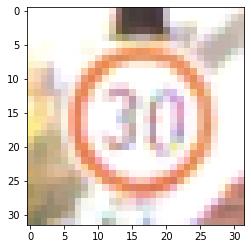

In [0]:
plt.imshow(X_test[400])

In [0]:
labels_dict[np.argmax(y_pred_prob[400])]  # np.argmax zwraca index wartości max

'Speed limit (30km/h)'

In [0]:
np.sum([3.3926887e-03, 8.8030541e-01, 4.1488703e-02, 1.0203755e-08,
       7.4765675e-02, 4.5594221e-05, 1.9140034e-06, 1.5110109e-09,
       1.5823006e-12, 3.2465544e-11, 9.3874943e-12, 5.4972937e-13,
       9.7367103e-10, 7.3153181e-14, 1.1929898e-12, 8.8969075e-12,
       1.6455027e-11, 8.3094630e-21, 8.2150073e-09, 3.2927199e-19,
       6.7255779e-17, 1.8019193e-12, 4.3595893e-24, 1.8816068e-16,
       3.8379181e-14, 3.0937672e-19, 1.6259617e-16, 1.2824036e-19,
       6.4358907e-10, 3.0165547e-15, 1.4446723e-15, 1.4620393e-11,
       3.2087441e-14, 1.2093990e-11, 2.2175653e-16, 7.3577000e-15,
       9.2140837e-25, 1.6293730e-13, 1.7626874e-12, 1.2778586e-13,
       3.8102286e-15, 4.2722680e-16, 2.8494386e-11])

1.0000000066011876

<BarContainer object of 43 artists>

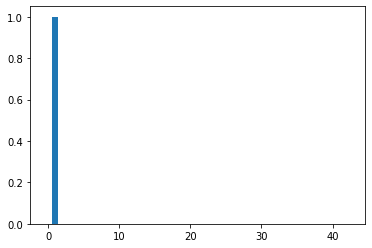

In [0]:
plt.bar(range(43), y_pred_prob[400])

In [0]:
y_pred_prob[400][y_pred_prob[400]>0.01]

array([0.9999999], dtype=float32)

In [0]:
for i in range(len(y_pred_prob[400])):
  if y_pred_prob[400][i] > 0.01:
    print(i,y_pred_prob[400][i],labels_dict[i])

1 0.9999999 Speed limit (30km/h)


# dalej

In [19]:
np.argmax(y_test, axis=1)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)   # np.argmax zwraca index, tu wskazane teże wg której osi, bo y_test to tablica tablic, czyli macierz

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [21]:
predict(model_trained, X_test, y_test)

0.83718820861678

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [0]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])


In [27]:
train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 4.6763 - accuracy: 0.2644 - val_loss: 1.3016 - val_accuracy: 0.6512
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 1.1101 - accuracy: 0.6723 - val_loss: 0.4092 - val_accuracy: 0.9013
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.5889 - accuracy: 0.8236 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.3840 - accuracy: 0.8858 - val_loss: 0.1054 - val_accuracy: 0.9761
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2778 - accuracy: 0.9172 - val_loss: 0.0576 - val_accuracy: 0.9884


0.9047619047619048

In [28]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 5s 19ms/step - loss: 2.8891 - accuracy: 0.4330 - val_loss: 0.4789 - val_accuracy: 0.8855
Epoch 2/5
272/272 [==============================] - 5s 18ms/step - loss: 0.5847 - accuracy: 0.8347 - val_loss: 0.1312 - val_accuracy: 0.9699
Epoch 3/5
272/272 [==============================] - 5s 18ms/step - loss: 0.3080 - accuracy: 0.9115 - val_loss: 0.0590 - val_accuracy: 0.9888
Epoch 4/5
272/272 [==============================] - 5s 19ms/step - loss: 0.2069 - accuracy: 0.9393 - val_loss: 0.0373 - val_accuracy: 0.9925
Epoch 5/5
272/272 [==============================] - 5s 18ms/step - loss: 0.1541 - accuracy: 0.9569 - val_loss: 0.0389 - val_accuracy: 0.9923


0.9682539682539683

In [29]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),   # padding dodaje parametrów do macierzy wejściowej (tu obrazka), żeby się za bardzo nie zmniejszył. Patrz dalej jak działają sieci konwolucyjne
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

# get_cnn_v4(input_shape, num_classes).summary()   #tu można zobaczyć output shape, czyli co wychodzi z każdej warstwy, możę się zdarzyć, że będzie mniej niż zero, wtedy będzie wyjątek
train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 2.6591 - accuracy: 0.2958 - val_loss: 0.9846 - val_accuracy: 0.7084
Epoch 2/5
272/272 [==============================] - 6s 21ms/step - loss: 0.8987 - accuracy: 0.7176 - val_loss: 0.3125 - val_accuracy: 0.9133
Epoch 3/5
272/272 [==============================] - 6s 21ms/step - loss: 0.4326 - accuracy: 0.8682 - val_loss: 0.0884 - val_accuracy: 0.9753
Epoch 4/5
272/272 [==============================] - 6s 21ms/step - loss: 0.2661 - accuracy: 0.9166 - val_loss: 0.0829 - val_accuracy: 0.9783
Epoch 5/5
272/272 [==============================] - 6s 21ms/step - loss: 0.1957 - accuracy: 0.9413 - val_loss: 0.0335 - val_accuracy: 0.9911


0.9702947845804989

In [30]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),   # padding dodaje parametrów do macierzy wejściowej (tu obrazka), żeby się za bardzo nie zmniejszył. Patrz dalej jak działają sieci konwolucyjne
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

# get_cnn_v4(input_shape, num_classes).summary()   #tu można zobaczyć output shape, czyli co wychodzi z każdej warstwy, możę się zdarzyć, że będzie mniej niż zero, wtedy będzie wyjątek
train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 6s 22ms/step - loss: 2.8211 - accuracy: 0.2538 - val_loss: 1.1272 - val_accuracy: 0.6361
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.8414 - accuracy: 0.7285 - val_loss: 0.2265 - val_accuracy: 0.9344
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.3654 - accuracy: 0.8849 - val_loss: 0.0870 - val_accuracy: 0.9772
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2320 - accuracy: 0.9306 - val_loss: 0.0359 - val_accuracy: 0.9900
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.1725 - accuracy: 0.9495 - val_loss: 0.0326 - val_accuracy: 0.9905


0.9798185941043084

# trzy kolory do szarości

In [31]:
X_train[0].shape

(32, 32, 3)

In [33]:
color.rgb2grey(X_train[0]).shape

(32, 32)

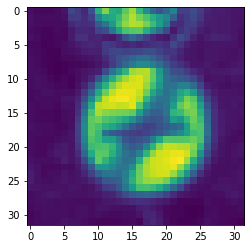

In [34]:
plt.imshow(color.rgb2grey(X_train[0]))

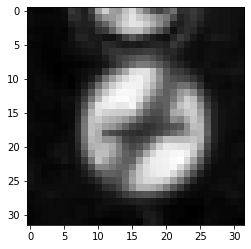

In [35]:
plt.imshow(color.rgb2grey(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
X_train_gray = color.rgb2grey(X_train)
X_test_gray = color.rgb2grey(X_test)

In [37]:
X_train_gray.shape, X_test_gray.shape

((34799, 32, 32), (4410, 32, 32))

In [39]:
X_train_gray.reshape(-1,32,32,1).shape

(34799, 32, 32, 1)

In [0]:
X_train_gray = color.rgb2grey(X_train).reshape(-1,32,32,1)
X_test_gray = color.rgb2grey(X_test).reshape(-1,32,32,1)

In [48]:
model = get_cnn_v5((32,32,1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 2.1908 - accuracy: 0.3705 - val_loss: 0.5478 - val_accuracy: 0.8107
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.5069 - accuracy: 0.8331 - val_loss: 0.1247 - val_accuracy: 0.9618
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2339 - accuracy: 0.9270 - val_loss: 0.0558 - val_accuracy: 0.9836
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 0.1520 - accuracy: 0.9524 - val_loss: 0.0493 - val_accuracy: 0.9863
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.1163 - accuracy: 0.9634 - val_loss: 0.0223 - val_accuracy: 0.9947


0.9689342403628118

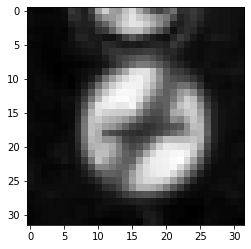

In [44]:
plt.imshow(color.rgb2grey(X_train[0]), cmap=plt.get_cmap('gray'))

# próba z Conv1D

In [0]:
from tensorflow.keras.layers import Conv1D

# ciekawostki...

przeczytać:
## https://github.com/joshwadd/Deep-traffic-sign-classification

In [0]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:,:,2] = exposure.equalize_adapthist(hsv[:,:,2])
  img = color.hsv2rgb(hsv)

  return img

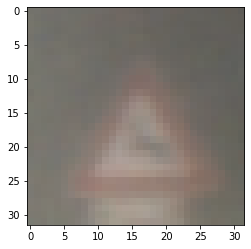

In [49]:
plt.imshow(X_train[400])

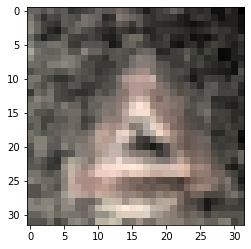

In [50]:
plt.imshow(preproc_img(X_train[400]))

In [52]:
X_train_prp = X_train.copy().astype(np.float32)
x_train_prp = X_train.copy().astype(np.float32)

for i in tqdm(range(X_train.shape[0])):
  X_train_prp[i] = preproc_img(X_train[i])

NameError: ignored

NameError: ignored